In [1]:
# !pip3 install opensmile
# !pip3 install audb
# !pip3 install audmetric
# !pip3 install audplot
# !pip3 install audonnx
# !pip3 install audinterface

import opensmile
import audeer
import audmetric
import audplot
import audinterface
import audonnx
import audb
import audformat


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

## Train

In [3]:
path_train = '/cephfs/home/chepel/MELD.Raw/train_splits/audio_train/'

In [4]:
# Готовый датасет с соотнесенными именами файлов и эмоциями
df_train = pd.read_csv('train_with_filenames.csv')

In [5]:
df_train['Full'] = df_train.Filename.map(lambda x: path_train+x)

In [6]:
smile = opensmile.Smile(
    opensmile.FeatureSet.ComParE_2016,
    opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,    
    resample=True,    
    num_workers=5,
    verbose=True,
)

In [9]:
feats_df = smile.process_files(tqdm(df_train.Full))

100%|███████████████████| 9989/9989 [00:00<00:00, 923164.61it/s]


In [11]:
feats_df.to_csv('train_features_new.csv', index=False)

In [21]:
# feats_df.to_csv('train_features.csv', index=False)

In [12]:
# Датасет с выделенными opensmile фичами
feats_df.head()

,,,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
file,start,end,,,,,,,,,,,,,,,,,,,,,
/cephfs/home/chepel/MELD.Raw/train_splits/audio_train/dia155_utt5.wav,0 days,0 days 00:00:02.133312500,1.727891,0.898058,0.839806,0.493364,0.696807,0.962219,0.203443,0.265412,0.468855,0.206875,...,10.350693,0.579441,3.124393,3.186151,-17.968100,0.377540,132.885559,54.681152,130.587662,58.500484
/cephfs/home/chepel/MELD.Raw/train_splits/audio_train/dia832_utt4.wav,0 days,0 days 00:00:01.386687500,0.675271,0.587786,0.992366,0.258411,0.337613,0.506090,0.079203,0.168476,0.247679,0.084714,...,7.319068,0.513860,3.352746,3.287592,18.016468,0.566474,146.077911,45.323669,126.520897,62.968010
/cephfs/home/chepel/MELD.Raw/train_splits/audio_train/dia273_utt9.wav,0 days,0 days 00:00:06.464000,1.907990,0.959311,0.244131,0.207355,0.318222,0.574279,0.110867,0.256058,0.366925,0.131163,...,7.767413,0.575642,2.277745,2.288213,-19.908001,0.482458,116.917458,57.943203,107.813904,54.425529
/cephfs/home/chepel/MELD.Raw/train_splits/audio_train/dia284_utt1.wav,0 days,0 days 00:00:00.576000,0.154609,0.040000,0.960000,0.115098,0.126571,0.156905,0.011474,0.030333,0.041807,0.104114,...,5.437149,0.441377,2.880050,2.773170,15.698260,0.546066,119.969696,44.301090,77.212486,77.472298
/cephfs/home/chepel/MELD.Raw/train_splits/audio_train/dia900_utt14.wav,0 days,0 days 00:00:01.130687500,0.585287,0.226415,0.726415,0.187042,0.224797,0.345244,0.037755,0.120447,0.158202,0.167261,...,2.822356,0.385321,2.105829,2.110164,-19.995193,0.703630,80.257408,60.178871,89.663536,43.384941


In [13]:
feats_df.shape

(9989, 6373)

## Тест

In [14]:
path_test = '/cephfs/home/chepel/MELD.Raw/train_splits/audio_test/'

In [15]:
df_test = pd.read_csv('test_with_filenames.csv')

In [16]:
df_test['Full'] = df_test.Filename.map(lambda x: path_test+x)

In [17]:
df_test.head()

,Filename,Emotion,Full
0,dia155_utt5.wav,sadness,/cephfs/home/chepel/MELD.Raw/train_splits/audi...
1,dia233_utt7.wav,joy,/cephfs/home/chepel/MELD.Raw/train_splits/audi...
2,dia95_utt4.wav,surprise,/cephfs/home/chepel/MELD.Raw/train_splits/audi...
3,dia268_utt11.wav,neutral,/cephfs/home/chepel/MELD.Raw/train_splits/audi...
4,dia169_utt17.wav,surprise,/cephfs/home/chepel/MELD.Raw/train_splits/audi...


In [18]:
feats_df_test = smile.process_files(df_test.Full)

In [65]:
# feats_df_test.to_csv('test_features.csv', index=False)

In [19]:
feats_df_test.to_csv('test_features_new.csv', index=False)

In [20]:
feats_df_test.shape

(2610, 6373)

## Обучение

In [21]:
 df = pd.read_csv('/cephfs/home/chepel/MELD.Raw/test_sent_emo.csv')

In [43]:
labels = sorted((df['Emotion'].unique()).tolist())
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [45]:
id2label

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

### SVM

In [22]:
from sklearn import svm

In [46]:
test_labels = df_test['Emotion'].replace(label2id)
train_labels = df_train['Emotion'].replace(label2id)

test_feats = feats_df_test
train_feats = feats_df

In [47]:
test_labels

0       5
1       3
2       6
3       4
4       6
       ..
2605    4
2606    4
2607    4
2608    0
2609    4
Name: Emotion, Length: 2610, dtype: int64

In [48]:
clf = svm.SVC()
clf = make_pipeline(
    StandardScaler(), 
    SVC(gamma='auto'),
)

In [49]:
clf.fit(train_feats, train_labels)
pred_labels  = clf.predict(test_feats)

In [50]:
print('F-1 score для smile + SVC = {:.2f}'.format(f1_score(test_labels, pred_labels, average='weighted')))

F-1 score для smile + SVC = 0.32


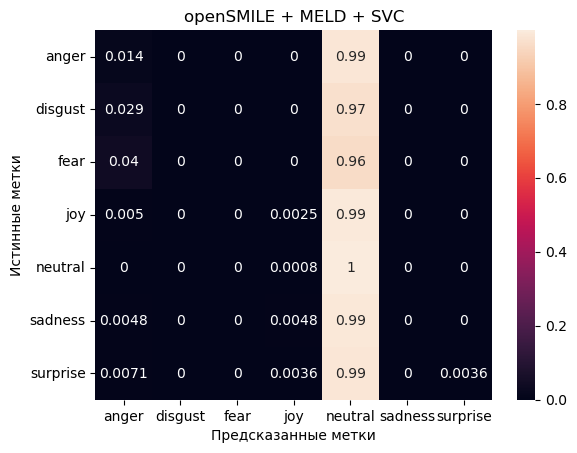

In [66]:
cm_1 = confusion_matrix(test_labels, pred_labels, normalize='true')
sns.heatmap(cm_1, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title(f'openSMILE + MELD + SVC')
plt.show()

### Naive Bayes

In [68]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_feats, train_labels)

GaussianNB()

In [69]:
pred_labels_nb  = clf.predict(test_feats)

In [70]:
print('F-1 score для smile + NB = {:.2f}'.format(f1_score(test_labels, pred_labels_nb, average='weighted')))

F-1 score для smile + NB = 0.31


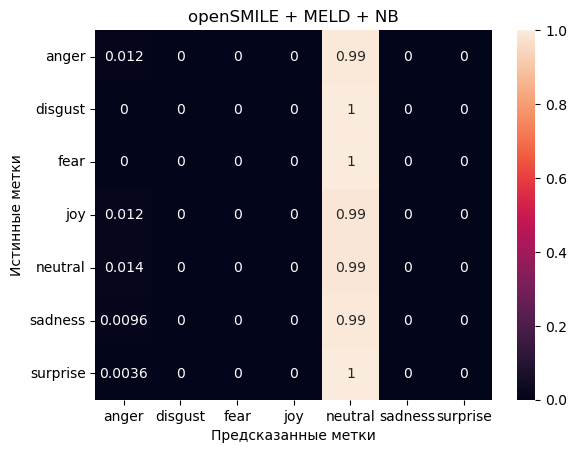

In [72]:
cm_1 = confusion_matrix(test_labels, pred_labels_nb, normalize='true')
sns.heatmap(cm_1, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title(f'openSMILE + MELD + NB')
plt.show()

### CatBoostClassifier

In [74]:
%pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [75]:
import catboost
from catboost import CatBoostClassifier

In [77]:
clf = CatBoostClassifier()
clf.fit(train_feats, train_labels)

Learning rate set to 0.088981
0:	learn: 1.8597503	total: 1.87s	remaining: 31m 12s
1:	learn: 1.7987253	total: 3.51s	remaining: 29m 10s
2:	learn: 1.7477310	total: 5.18s	remaining: 28m 41s
3:	learn: 1.7103492	total: 6.88s	remaining: 28m 32s
4:	learn: 1.6789674	total: 8.69s	remaining: 28m 48s
5:	learn: 1.6507903	total: 10.7s	remaining: 29m 27s
6:	learn: 1.6284324	total: 12.7s	remaining: 30m 2s
7:	learn: 1.6087558	total: 14.6s	remaining: 30m 11s
8:	learn: 1.5930704	total: 16.5s	remaining: 30m 16s
9:	learn: 1.5788642	total: 18.4s	remaining: 30m 19s
10:	learn: 1.5655646	total: 20.2s	remaining: 30m 13s
11:	learn: 1.5536933	total: 21.9s	remaining: 30m
12:	learn: 1.5431733	total: 23.5s	remaining: 29m 44s
13:	learn: 1.5345414	total: 25.2s	remaining: 29m 33s
14:	learn: 1.5269966	total: 26.8s	remaining: 29m 19s
15:	learn: 1.5194303	total: 28.4s	remaining: 29m 7s
16:	learn: 1.5131640	total: 30.1s	remaining: 29m
17:	learn: 1.5071497	total: 31.9s	remaining: 28m 59s
18:	learn: 1.5018843	total: 33.6s	re

153:	learn: 1.2172983	total: 4m 48s	remaining: 26m 22s
154:	learn: 1.2150772	total: 4m 49s	remaining: 26m 20s
155:	learn: 1.2128149	total: 4m 51s	remaining: 26m 19s
156:	learn: 1.2117123	total: 4m 53s	remaining: 26m 18s
157:	learn: 1.2097553	total: 4m 55s	remaining: 26m 16s
158:	learn: 1.2083101	total: 4m 57s	remaining: 26m 15s
159:	learn: 1.2071412	total: 4m 59s	remaining: 26m 13s
160:	learn: 1.2050752	total: 5m 1s	remaining: 26m 12s
161:	learn: 1.2029871	total: 5m 3s	remaining: 26m 9s
162:	learn: 1.2011008	total: 5m 5s	remaining: 26m 8s
163:	learn: 1.1992588	total: 5m 7s	remaining: 26m 6s
164:	learn: 1.1974971	total: 5m 9s	remaining: 26m 4s
165:	learn: 1.1967563	total: 5m 11s	remaining: 26m 3s
166:	learn: 1.1949227	total: 5m 13s	remaining: 26m 1s
167:	learn: 1.1930049	total: 5m 14s	remaining: 25m 59s
168:	learn: 1.1917202	total: 5m 16s	remaining: 25m 58s
169:	learn: 1.1901575	total: 5m 18s	remaining: 25m 56s
170:	learn: 1.1885105	total: 5m 20s	remaining: 25m 54s
171:	learn: 1.1869101

304:	learn: 0.9862015	total: 9m 15s	remaining: 21m 4s
305:	learn: 0.9846483	total: 9m 16s	remaining: 21m 2s
306:	learn: 0.9835318	total: 9m 18s	remaining: 21m
307:	learn: 0.9818157	total: 9m 20s	remaining: 20m 58s
308:	learn: 0.9799064	total: 9m 21s	remaining: 20m 56s
309:	learn: 0.9783526	total: 9m 23s	remaining: 20m 53s
310:	learn: 0.9765436	total: 9m 24s	remaining: 20m 51s
311:	learn: 0.9750990	total: 9m 26s	remaining: 20m 49s
312:	learn: 0.9735080	total: 9m 28s	remaining: 20m 47s
313:	learn: 0.9717465	total: 9m 29s	remaining: 20m 44s
314:	learn: 0.9703812	total: 9m 31s	remaining: 20m 42s
315:	learn: 0.9690756	total: 9m 33s	remaining: 20m 40s
316:	learn: 0.9680524	total: 9m 34s	remaining: 20m 38s
317:	learn: 0.9662124	total: 9m 36s	remaining: 20m 36s
318:	learn: 0.9650873	total: 9m 38s	remaining: 20m 34s
319:	learn: 0.9642438	total: 9m 39s	remaining: 20m 31s
320:	learn: 0.9627896	total: 9m 41s	remaining: 20m 29s
321:	learn: 0.9616014	total: 9m 42s	remaining: 20m 27s
322:	learn: 0.96

453:	learn: 0.8054073	total: 13m 17s	remaining: 15m 59s
454:	learn: 0.8042051	total: 13m 19s	remaining: 15m 57s
455:	learn: 0.8031851	total: 13m 20s	remaining: 15m 55s
456:	learn: 0.8022436	total: 13m 22s	remaining: 15m 53s
457:	learn: 0.8012038	total: 13m 24s	remaining: 15m 51s
458:	learn: 0.7996738	total: 13m 25s	remaining: 15m 49s
459:	learn: 0.7985282	total: 13m 27s	remaining: 15m 47s
460:	learn: 0.7971118	total: 13m 29s	remaining: 15m 45s
461:	learn: 0.7962049	total: 13m 30s	remaining: 15m 44s
462:	learn: 0.7949060	total: 13m 32s	remaining: 15m 42s
463:	learn: 0.7937234	total: 13m 34s	remaining: 15m 40s
464:	learn: 0.7924724	total: 13m 35s	remaining: 15m 38s
465:	learn: 0.7911262	total: 13m 37s	remaining: 15m 36s
466:	learn: 0.7903650	total: 13m 38s	remaining: 15m 34s
467:	learn: 0.7891907	total: 13m 40s	remaining: 15m 32s
468:	learn: 0.7877133	total: 13m 42s	remaining: 15m 30s
469:	learn: 0.7865922	total: 13m 43s	remaining: 15m 29s
470:	learn: 0.7854193	total: 13m 45s	remaining: 

601:	learn: 0.6615971	total: 17m 19s	remaining: 11m 27s
602:	learn: 0.6610626	total: 17m 21s	remaining: 11m 25s
603:	learn: 0.6601661	total: 17m 22s	remaining: 11m 23s
604:	learn: 0.6595694	total: 17m 24s	remaining: 11m 21s
605:	learn: 0.6587606	total: 17m 25s	remaining: 11m 20s
606:	learn: 0.6581472	total: 17m 27s	remaining: 11m 18s
607:	learn: 0.6574438	total: 17m 29s	remaining: 11m 16s
608:	learn: 0.6563142	total: 17m 30s	remaining: 11m 14s
609:	learn: 0.6556398	total: 17m 32s	remaining: 11m 12s
610:	learn: 0.6549248	total: 17m 34s	remaining: 11m 11s
611:	learn: 0.6545264	total: 17m 35s	remaining: 11m 9s
612:	learn: 0.6540237	total: 17m 37s	remaining: 11m 7s
613:	learn: 0.6533147	total: 17m 38s	remaining: 11m 5s
614:	learn: 0.6524222	total: 17m 40s	remaining: 11m 3s
615:	learn: 0.6516685	total: 17m 41s	remaining: 11m 1s
616:	learn: 0.6506917	total: 17m 43s	remaining: 11m
617:	learn: 0.6496717	total: 17m 45s	remaining: 10m 58s
618:	learn: 0.6489460	total: 17m 46s	remaining: 10m 56s
6

751:	learn: 0.5522928	total: 21m 24s	remaining: 7m 3s
752:	learn: 0.5514912	total: 21m 26s	remaining: 7m 1s
753:	learn: 0.5506804	total: 21m 28s	remaining: 7m
754:	learn: 0.5501035	total: 21m 29s	remaining: 6m 58s
755:	learn: 0.5494320	total: 21m 31s	remaining: 6m 56s
756:	learn: 0.5487236	total: 21m 33s	remaining: 6m 55s
757:	learn: 0.5481151	total: 21m 34s	remaining: 6m 53s
758:	learn: 0.5471485	total: 21m 36s	remaining: 6m 51s
759:	learn: 0.5463451	total: 21m 37s	remaining: 6m 49s
760:	learn: 0.5457112	total: 21m 39s	remaining: 6m 48s
761:	learn: 0.5446831	total: 21m 41s	remaining: 6m 46s
762:	learn: 0.5441350	total: 21m 42s	remaining: 6m 44s
763:	learn: 0.5434765	total: 21m 44s	remaining: 6m 43s
764:	learn: 0.5427719	total: 21m 46s	remaining: 6m 41s
765:	learn: 0.5424282	total: 21m 48s	remaining: 6m 39s
766:	learn: 0.5417727	total: 21m 49s	remaining: 6m 37s
767:	learn: 0.5410474	total: 21m 51s	remaining: 6m 36s
768:	learn: 0.5403449	total: 21m 52s	remaining: 6m 34s
769:	learn: 0.53

902:	learn: 0.4614132	total: 25m 26s	remaining: 2m 43s
903:	learn: 0.4609940	total: 25m 28s	remaining: 2m 42s
904:	learn: 0.4604378	total: 25m 29s	remaining: 2m 40s
905:	learn: 0.4599016	total: 25m 31s	remaining: 2m 38s
906:	learn: 0.4593356	total: 25m 33s	remaining: 2m 37s
907:	learn: 0.4588009	total: 25m 34s	remaining: 2m 35s
908:	learn: 0.4583192	total: 25m 36s	remaining: 2m 33s
909:	learn: 0.4579869	total: 25m 38s	remaining: 2m 32s
910:	learn: 0.4575903	total: 25m 39s	remaining: 2m 30s
911:	learn: 0.4567719	total: 25m 41s	remaining: 2m 28s
912:	learn: 0.4563144	total: 25m 43s	remaining: 2m 27s
913:	learn: 0.4557977	total: 25m 44s	remaining: 2m 25s
914:	learn: 0.4553496	total: 25m 46s	remaining: 2m 23s
915:	learn: 0.4547109	total: 25m 48s	remaining: 2m 21s
916:	learn: 0.4542771	total: 25m 49s	remaining: 2m 20s
917:	learn: 0.4538828	total: 25m 51s	remaining: 2m 18s
918:	learn: 0.4533964	total: 25m 52s	remaining: 2m 16s
919:	learn: 0.4527332	total: 25m 54s	remaining: 2m 15s
920:	learn

In [78]:
pred_labels_cat  = clf.predict(test_feats)

In [79]:
print('F-1 score для smile + Catboost = {:.2f}'.format(f1_score(test_labels, pred_labels_cat, average='weighted')))

F-1 score для smile + Catboost = 0.38


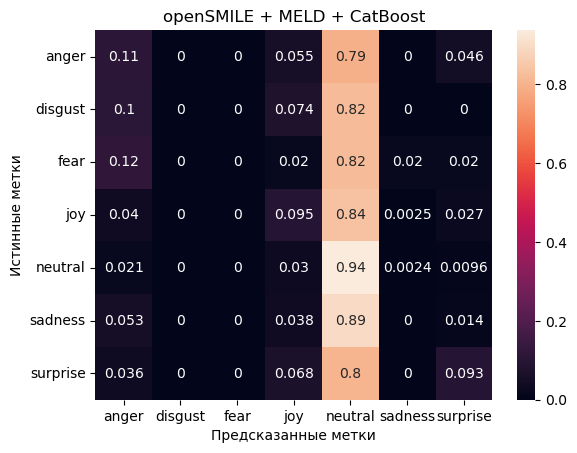

In [80]:
cm_1 = confusion_matrix(test_labels, pred_labels_cat, normalize='true')
sns.heatmap(cm_1, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title(f'openSMILE + MELD + CatBoost')
plt.show()

### CatBoostClassifier + выделенные важные фичи

In [103]:
feature_imp = clf.get_feature_importance(prettified=True)

In [84]:
feature_imp

,Feature Id,Importances
0,F0final_sma_leftctime,0.278223
1,F0final_sma_de_quartile3,0.241872
2,mfcc_sma[4]_maxPos,0.240255
3,mfcc_sma[14]_lpgain,0.229202
4,mfcc_sma[9]_qregc3,0.186578
...,...,...
6368,mfcc_sma_de[14]_peakRangeAbs,0.000000
6369,mfcc_sma_de[14]_peakMeanMeanDist,0.000000
6370,mfcc_sma_de[14]_minRangeRel,0.000000
6371,mfcc_sma_de[14]_meanRisingSlope,0.000000


In [88]:
weak_features = feature_imp[feature_imp['Importances'] < 0.06]

In [89]:
weak_features

,Feature Id,Importances
335,audSpec_Rfilt_sma_de[20]_peakRangeRel,0.059956
336,audSpec_Rfilt_sma[2]_maxPos,0.059941
337,pcm_fftMag_fband1000-4000_sma_de_lpc1,0.059934
338,mfcc_sma[12]_peakMeanMeanDist,0.059908
339,pcm_fftMag_spectralSkewness_sma_de_iqr1-2,0.059862
...,...,...
6368,mfcc_sma_de[14]_peakRangeAbs,0.000000
6369,mfcc_sma_de[14]_peakMeanMeanDist,0.000000
6370,mfcc_sma_de[14]_minRangeRel,0.000000
6371,mfcc_sma_de[14]_meanRisingSlope,0.000000


In [91]:
feats_df_test_strong = feats_df_test.drop(weak_features['Feature Id'], axis=1)

In [92]:
feats_df_strong = feats_df.drop(weak_features['Feature Id'], axis=1)

In [95]:
test_feats_strong = feats_df_test_strong
train_feats_strong = feats_df_strong

In [96]:
clf_strong = CatBoostClassifier()
clf_strong.fit(train_feats_strong, train_labels)

Learning rate set to 0.088981
0:	learn: 1.8610307	total: 75.2ms	remaining: 1m 15s
1:	learn: 1.7973144	total: 171ms	remaining: 1m 25s
2:	learn: 1.7469042	total: 266ms	remaining: 1m 28s
3:	learn: 1.7070786	total: 362ms	remaining: 1m 30s
4:	learn: 1.6750286	total: 459ms	remaining: 1m 31s
5:	learn: 1.6479449	total: 558ms	remaining: 1m 32s
6:	learn: 1.6232071	total: 612ms	remaining: 1m 26s
7:	learn: 1.6030986	total: 705ms	remaining: 1m 27s
8:	learn: 1.5865267	total: 803ms	remaining: 1m 28s
9:	learn: 1.5703069	total: 903ms	remaining: 1m 29s
10:	learn: 1.5564694	total: 1s	remaining: 1m 29s
11:	learn: 1.5452777	total: 1.09s	remaining: 1m 30s
12:	learn: 1.5344793	total: 1.19s	remaining: 1m 30s
13:	learn: 1.5254957	total: 1.29s	remaining: 1m 30s
14:	learn: 1.5172948	total: 1.39s	remaining: 1m 31s
15:	learn: 1.5096198	total: 1.48s	remaining: 1m 31s
16:	learn: 1.5036752	total: 1.58s	remaining: 1m 31s
17:	learn: 1.4975192	total: 1.68s	remaining: 1m 31s
18:	learn: 1.4925450	total: 1.77s	remaining: 1

157:	learn: 1.1973142	total: 14.8s	remaining: 1m 19s
158:	learn: 1.1962633	total: 14.9s	remaining: 1m 19s
159:	learn: 1.1947672	total: 15s	remaining: 1m 18s
160:	learn: 1.1931254	total: 15.1s	remaining: 1m 18s
161:	learn: 1.1911313	total: 15.2s	remaining: 1m 18s
162:	learn: 1.1894092	total: 15.3s	remaining: 1m 18s
163:	learn: 1.1878035	total: 15.4s	remaining: 1m 18s
164:	learn: 1.1861548	total: 15.5s	remaining: 1m 18s
165:	learn: 1.1841935	total: 15.6s	remaining: 1m 18s
166:	learn: 1.1821972	total: 15.7s	remaining: 1m 18s
167:	learn: 1.1804080	total: 15.8s	remaining: 1m 18s
168:	learn: 1.1786194	total: 15.9s	remaining: 1m 17s
169:	learn: 1.1765382	total: 15.9s	remaining: 1m 17s
170:	learn: 1.1745368	total: 16s	remaining: 1m 17s
171:	learn: 1.1732516	total: 16.1s	remaining: 1m 17s
172:	learn: 1.1716925	total: 16.2s	remaining: 1m 17s
173:	learn: 1.1692952	total: 16.3s	remaining: 1m 17s
174:	learn: 1.1673588	total: 16.4s	remaining: 1m 17s
175:	learn: 1.1656452	total: 16.5s	remaining: 1m 1

316:	learn: 0.9521512	total: 29.6s	remaining: 1m 3s
317:	learn: 0.9506784	total: 29.8s	remaining: 1m 3s
318:	learn: 0.9496367	total: 29.8s	remaining: 1m 3s
319:	learn: 0.9485743	total: 29.9s	remaining: 1m 3s
320:	learn: 0.9475245	total: 30s	remaining: 1m 3s
321:	learn: 0.9461953	total: 30.1s	remaining: 1m 3s
322:	learn: 0.9447191	total: 30.2s	remaining: 1m 3s
323:	learn: 0.9431314	total: 30.3s	remaining: 1m 3s
324:	learn: 0.9415012	total: 30.4s	remaining: 1m 3s
325:	learn: 0.9401747	total: 30.5s	remaining: 1m 3s
326:	learn: 0.9387314	total: 30.6s	remaining: 1m 3s
327:	learn: 0.9369860	total: 30.7s	remaining: 1m 2s
328:	learn: 0.9356729	total: 30.8s	remaining: 1m 2s
329:	learn: 0.9341353	total: 30.9s	remaining: 1m 2s
330:	learn: 0.9330023	total: 31s	remaining: 1m 2s
331:	learn: 0.9316777	total: 31.1s	remaining: 1m 2s
332:	learn: 0.9303867	total: 31.2s	remaining: 1m 2s
333:	learn: 0.9289593	total: 31.3s	remaining: 1m 2s
334:	learn: 0.9279258	total: 31.3s	remaining: 1m 2s
335:	learn: 0.92

478:	learn: 0.7591350	total: 44.8s	remaining: 48.7s
479:	learn: 0.7580944	total: 44.9s	remaining: 48.7s
480:	learn: 0.7567343	total: 45s	remaining: 48.6s
481:	learn: 0.7555003	total: 45.1s	remaining: 48.5s
482:	learn: 0.7547733	total: 45.2s	remaining: 48.4s
483:	learn: 0.7538682	total: 45.3s	remaining: 48.3s
484:	learn: 0.7529803	total: 45.4s	remaining: 48.2s
485:	learn: 0.7519894	total: 45.5s	remaining: 48.1s
486:	learn: 0.7511107	total: 45.6s	remaining: 48s
487:	learn: 0.7500034	total: 45.7s	remaining: 47.9s
488:	learn: 0.7489491	total: 45.8s	remaining: 47.8s
489:	learn: 0.7481503	total: 45.9s	remaining: 47.7s
490:	learn: 0.7469826	total: 46s	remaining: 47.7s
491:	learn: 0.7461011	total: 46.1s	remaining: 47.6s
492:	learn: 0.7449376	total: 46.2s	remaining: 47.5s
493:	learn: 0.7440609	total: 46.2s	remaining: 47.3s
494:	learn: 0.7432473	total: 46.3s	remaining: 47.3s
495:	learn: 0.7421012	total: 46.4s	remaining: 47.2s
496:	learn: 0.7412985	total: 46.5s	remaining: 47.1s
497:	learn: 0.7403

637:	learn: 0.6231484	total: 59.5s	remaining: 33.8s
638:	learn: 0.6220225	total: 59.6s	remaining: 33.7s
639:	learn: 0.6208436	total: 59.7s	remaining: 33.6s
640:	learn: 0.6199572	total: 59.8s	remaining: 33.5s
641:	learn: 0.6194875	total: 59.9s	remaining: 33.4s
642:	learn: 0.6185790	total: 60s	remaining: 33.3s
643:	learn: 0.6178234	total: 1m	remaining: 33.2s
644:	learn: 0.6170438	total: 1m	remaining: 33.1s
645:	learn: 0.6162656	total: 1m	remaining: 33s
646:	learn: 0.6154726	total: 1m	remaining: 32.9s
647:	learn: 0.6146820	total: 1m	remaining: 32.9s
648:	learn: 0.6141497	total: 1m	remaining: 32.8s
649:	learn: 0.6133430	total: 1m	remaining: 32.7s
650:	learn: 0.6127096	total: 1m	remaining: 32.6s
651:	learn: 0.6122683	total: 1m	remaining: 32.5s
652:	learn: 0.6116785	total: 1m	remaining: 32.4s
653:	learn: 0.6108121	total: 1m 1s	remaining: 32.3s
654:	learn: 0.6101549	total: 1m 1s	remaining: 32.2s
655:	learn: 0.6095623	total: 1m 1s	remaining: 32.1s
656:	learn: 0.6088363	total: 1m 1s	remaining: 

797:	learn: 0.5118914	total: 1m 14s	remaining: 18.9s
798:	learn: 0.5113417	total: 1m 14s	remaining: 18.8s
799:	learn: 0.5106682	total: 1m 14s	remaining: 18.7s
800:	learn: 0.5100875	total: 1m 14s	remaining: 18.6s
801:	learn: 0.5091977	total: 1m 14s	remaining: 18.5s
802:	learn: 0.5087781	total: 1m 15s	remaining: 18.4s
803:	learn: 0.5082732	total: 1m 15s	remaining: 18.3s
804:	learn: 0.5073965	total: 1m 15s	remaining: 18.2s
805:	learn: 0.5069895	total: 1m 15s	remaining: 18.1s
806:	learn: 0.5065583	total: 1m 15s	remaining: 18s
807:	learn: 0.5060103	total: 1m 15s	remaining: 17.9s
808:	learn: 0.5053380	total: 1m 15s	remaining: 17.9s
809:	learn: 0.5047458	total: 1m 15s	remaining: 17.8s
810:	learn: 0.5040554	total: 1m 15s	remaining: 17.7s
811:	learn: 0.5037829	total: 1m 15s	remaining: 17.6s
812:	learn: 0.5032314	total: 1m 16s	remaining: 17.5s
813:	learn: 0.5026388	total: 1m 16s	remaining: 17.4s
814:	learn: 0.5021238	total: 1m 16s	remaining: 17.3s
815:	learn: 0.5015172	total: 1m 16s	remaining: 1

953:	learn: 0.4256163	total: 1m 29s	remaining: 4.32s
954:	learn: 0.4252358	total: 1m 29s	remaining: 4.22s
955:	learn: 0.4245056	total: 1m 29s	remaining: 4.13s
956:	learn: 0.4242935	total: 1m 29s	remaining: 4.03s
957:	learn: 0.4239877	total: 1m 29s	remaining: 3.94s
958:	learn: 0.4236215	total: 1m 29s	remaining: 3.85s
959:	learn: 0.4230874	total: 1m 30s	remaining: 3.75s
960:	learn: 0.4225609	total: 1m 30s	remaining: 3.66s
961:	learn: 0.4223767	total: 1m 30s	remaining: 3.56s
962:	learn: 0.4220776	total: 1m 30s	remaining: 3.47s
963:	learn: 0.4217544	total: 1m 30s	remaining: 3.38s
964:	learn: 0.4213540	total: 1m 30s	remaining: 3.28s
965:	learn: 0.4211539	total: 1m 30s	remaining: 3.19s
966:	learn: 0.4207133	total: 1m 30s	remaining: 3.1s
967:	learn: 0.4201093	total: 1m 30s	remaining: 3s
968:	learn: 0.4196517	total: 1m 30s	remaining: 2.91s
969:	learn: 0.4191592	total: 1m 30s	remaining: 2.81s
970:	learn: 0.4187108	total: 1m 31s	remaining: 2.72s
971:	learn: 0.4184556	total: 1m 31s	remaining: 2.6

In [98]:
pred_labels_cat_strong  = clf_strong.predict(test_feats_strong)

In [99]:
print('F-1 score для smile + Catboost = {:.2f}'.format(f1_score(test_labels, pred_labels_cat_strong, average='weighted')))

F-1 score для smile + Catboost = 0.37


In [ ]:
# от отбрасывания малозначимых фичей результаты лучше не стали - f-1 только просел :(

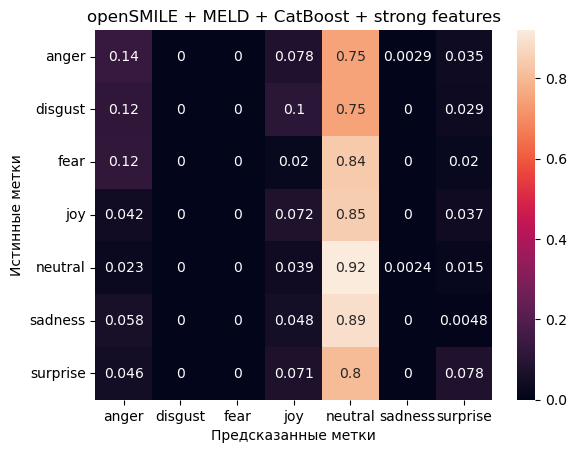

In [101]:
cm_1 = confusion_matrix(test_labels, pred_labels_cat_strong, normalize='true')
sns.heatmap(cm_1, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.title(f'openSMILE + MELD + CatBoost + strong features')
plt.show()